# Real or Not? NLP with Disaster Tweets

Соревнование для знакомства с NLP.

Задача бинарной классификации. Необходимо проанализировать твиты и сделать выводы о том, в каких из них речь идет о реальных бедствиях, а где нет.

In [43]:
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import defaultdict
from collections import Counter
from matplotlib import pyplot as plt

%matplotlib inline

### Загружаем данные для анализа

In [3]:
train_data = pd.read_csv("data/train.csv", index_col="id")
test_data = pd.read_csv("data/test.csv", index_col="id")
print(f"Shape of train data: {train_data.shape}. Shape of test data: {test_data.shape}")
train_data.head()

Shape of train data: (7613, 4). Shape of test data: (3263, 3)


,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


### Анализируем целевую переменную

In [5]:
train_data['target'].describe()

count    7613.00000
mean        0.42966
std         0.49506
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max         1.00000
Name: target, dtype: float64

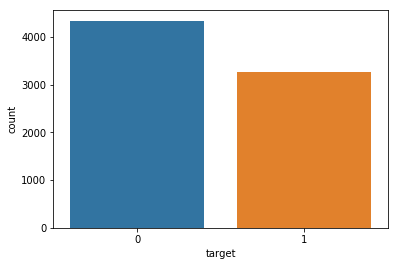

In [6]:
sns.countplot(x='target', data=train_data)

Вывод: классы неплохо сбалансированы

### Пропуски в данных

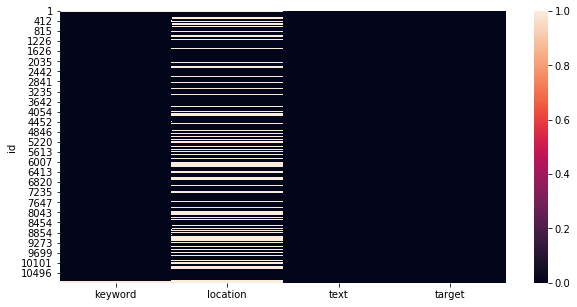

In [7]:
plt.figure(figsize=(10,5))
sns.heatmap(train_data.isnull());

### Количество уникальных значений

In [8]:
train_data.nunique()

keyword      221
location    3341
text        7503
target         2
dtype: int64

### Признак "Ключевое слово"

In [9]:
train_data['keyword'].unique()[:20]

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze'],
      dtype=object)

### Признак "Локация"

In [10]:
train_data['location'].unique()[:20]

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', 'AFRICA',
       'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!',
       'Paranaque City', 'Live On Webcam', 'milky way',
       'GREENSBORO,NORTH CAROLINA', 'England.',
       'Sheffield Township, Ohio', 'India', 'Barbados', 'Anaheim',
       'Abuja', 'USA', 'South Africa'], dtype=object)

### Текст сообщений
Для начала базовая аналитика на уровне символов, слов и выражений

**Количество символов в твитах**

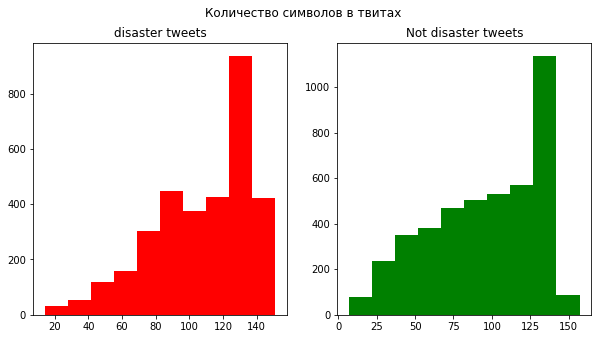

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_data[train_data['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train_data[train_data['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Количество символов в твитах')
plt.show()

Распределения по количеству символов схожи

**Количество слов в твитах**

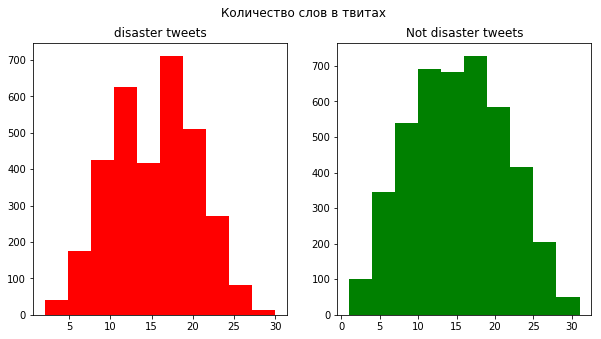

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_data[train_data['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train_data[train_data['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Количество слов в твитах')
plt.show()

**Средняя длина слова в твитах**

Text(0.5, 0.98, 'Средняя длина слова в каждом твите')

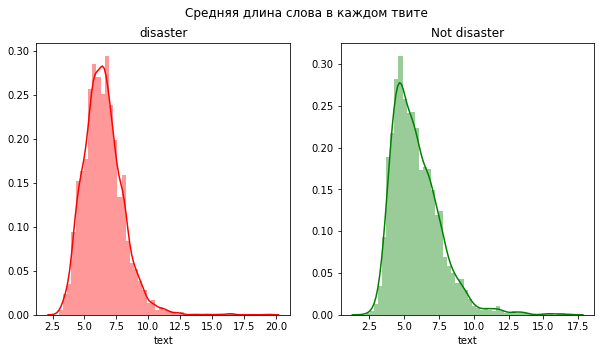

In [16]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
word = train_data[train_data['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word = train_data[train_data['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Средняя длина слова в каждом твите')

In [17]:
def create_corpus(target):
    corpus=[]
    
    for x in train_data[train_data['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

**Общие стоп-слова (шумовые слова) в твитах**

In [28]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tarasovnm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<BarContainer object of 10 artists>

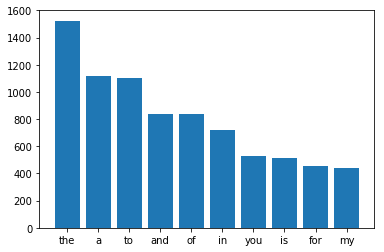

In [30]:
corpus = create_corpus(0)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
        
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y = zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

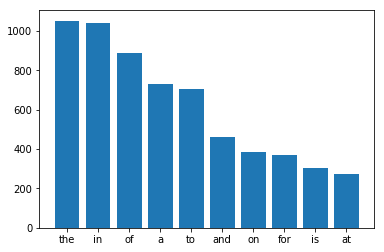

In [31]:
corpus = create_corpus(1)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    
x,y = zip(*top)
plt.bar(x,y)

**Анализируем пунктуацию**

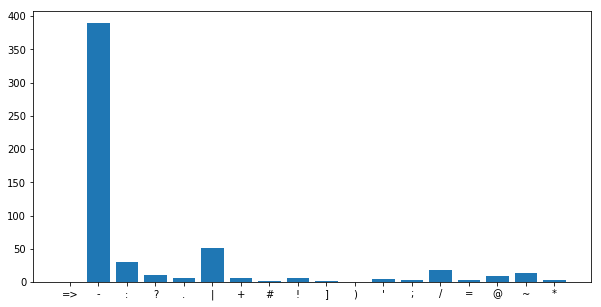

In [36]:
plt.figure(figsize=(10,5))
corpus = create_corpus(1)

dic = defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i] += 1
        
x,y = zip(*dic.items())
plt.bar(x,y);

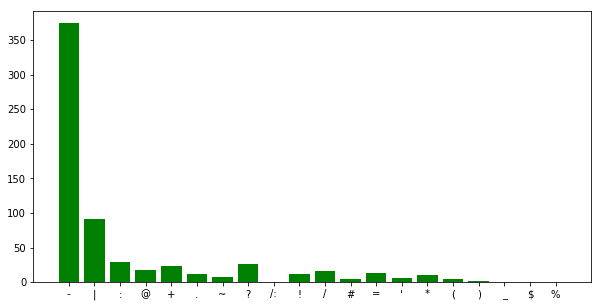

In [35]:
plt.figure(figsize=(10,5))
corpus = create_corpus(0)

dic = defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i] += 1
        
x,y = zip(*dic.items())
plt.bar(x,y,color='green');

**Общие слова?**

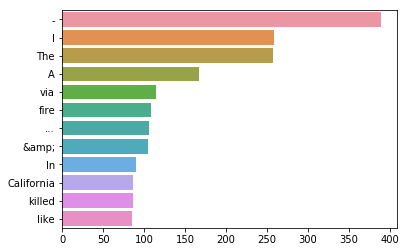

In [39]:
counter = Counter(corpus)
most = counter.most_common()
x = []
y = []
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

Требуется очистка данных!

**Анализ n-грам**

Будем анализировать би-грамы

In [40]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

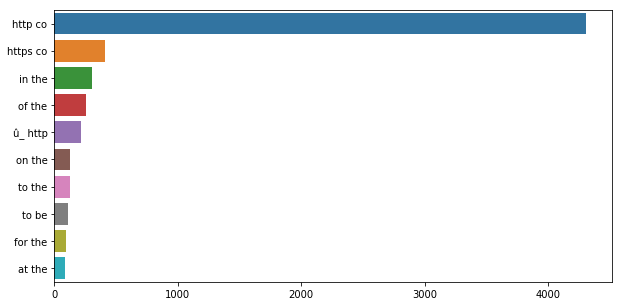

In [44]:
plt.figure(figsize=(10,5))
top_tweet_bigrams = get_top_tweet_bigrams(train_data['text'])[:10]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

Необходимо почистить данные

In [ ]:
# https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
# https://www.kaggle.com/singhshubhamrana/twitter-tweet-model-for-identifying-real-disaster